In [1]:
import pickle
import sys
sys.path.append('../../..')
import numpy as np
from scipy.interpolate import interp1d
from tqdm import tqdm_notebook as tqdm

import config
from config import load_data
import main
from darkhistory.electrons.elec_cooling import get_elec_cooling_tf
import darkhistory.history.tla as tla
import darkhistory.low_energy.lowE_electrons as lowE_elec
import darkhistory.physics as phys
import darkhistory.utilities as utils

import matplotlib
matplotlib.rc_file('../../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'

# MEDEA

An electron of energy $E'$ injected into the IGM will lose its energy through a number of different channels $c$. We define the fraction of energy that the electron lost to a given channel as $R_c(E')$. In this cross-check we compare our computation of $R_c(E')$ to [MEDEA's data tables](https://doi.org/10.1111/j.1365-2966.2012.20624.x).

In [2]:
# Load data.
binning = load_data('binning')
photeng = binning['phot']
eleceng = binning['elec']

dep_tf_data = load_data('dep_tf')
ics_tf_data = load_data('ics_tf')
ics_thomson_ref_tf  = ics_tf_data['thomson']
ics_rel_ref_tf      = ics_tf_data['rel']
engloss_ref_tf      = ics_tf_data['engloss']

#MEDEA
H_states = ['2s', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p', '10p']
(
    coll_ion_sec_elec_specs, coll_exc_sec_elec_specs,
    ics_engloss_data
) = main.get_elec_cooling_data(eleceng, photeng, H_states=H_states)

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


In [3]:
# Probs that a given state decays ultimately to '2p'
# See Table I of astro-ph/0507102
Ps = {'2p': 1.0000, '2s': 0.0, '3p': 0.0,
      '4p': 0.2609,'5p': 0.3078,'6p': 0.3259,
      '7p': 0.3353,'8p': 0.3410,'9p': 0.3448,'10p': 0.3476}

#ionization levels probed by MEDEA
xes = np.array([
    1e-4, 1.5e-4, 2e-4, 3e-4, 5e-4,
    1e-3, 1.5e-3, 2e-3, 3e-3, 5e-3,
    1e-2, 1.5e-2, 2e-2, 3e-2, 5e-2,
    1e-1, 1.5e-1, 2e-1, 3e-1, 5e-1,
    7e-1, 8e-1, 9e-1, 9.5e-1, 9.9e-1, 
    1.0
])

channels = ['heat', 'excitation', 'H ionization', 'He ionization', 'continuum']
fs = {chan: np.zeros((xes.size, eleceng.size)) for chan in channels}

In [4]:
rs=1
for i,xHII in enumerate(tqdm(xes)):
    (
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_arr
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII, xHeII=xHII * phys.chi,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            H_states=H_states,
            check_conservation_eng=True
        )

    fs['heat'][i]   = deposited_heat_arr/eleceng
    fs['H ionization'][i]  = deposited_ion_arr['H']/eleceng
    fs['He ionization'][i] = deposited_ion_arr['He']/eleceng
    fs['excitation'][i]  = np.sum([
        deposited_exc_arr[species]*Ps[species] * phys.lya_eng/phys.H_exc_eng(species)
    for species in Ps], axis=0)/eleceng
    fs['continuum'][i] = np.sum([
        deposited_exc_arr[species]*((1-Ps[species]) + Ps[species] * (1-phys.lya_eng/phys.H_exc_eng(species)))
    for species in Ps], axis=0)/eleceng + (
    deposited_ICS_arr/eleceng)

In [5]:
our_fs = np.array([fs[chan] for chan in channels])
our_fs = our_fs.swapaxes(0,2)
our_fs = our_fs.swapaxes(0,1)

MEDEA_interp = lowE_elec.make_interpolator()
DH_interp = utils.Interpolator2D(
    xes, 'xes', eleceng, 'engs', our_fs, logInterp=True
)

/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1e-20, top=1e-20
  self.set_ylim(upper, lower, auto=None)


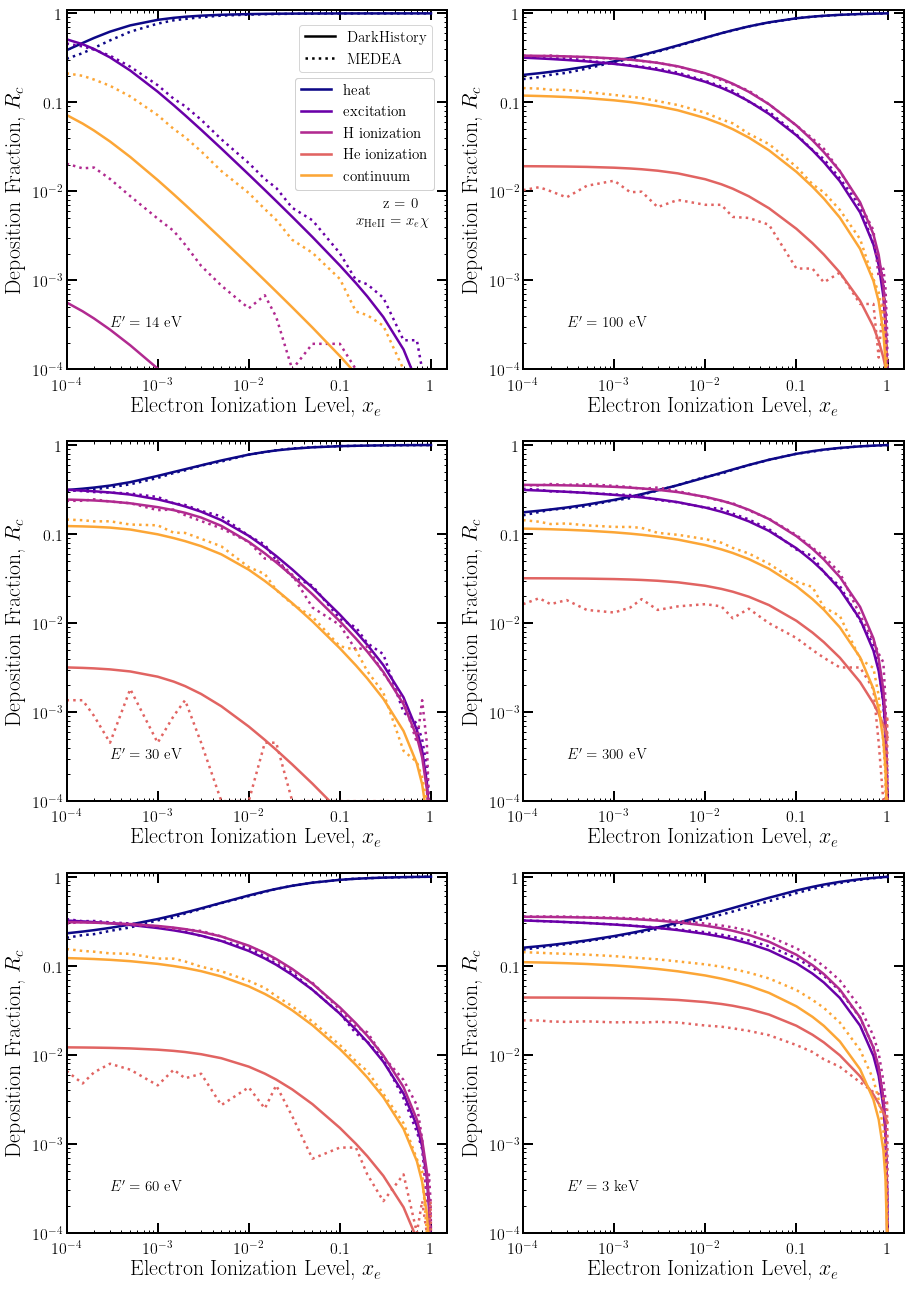

In [6]:
initEs = np.array([14, 30, 60, 100, 300, 3000])
n_fig_col = 3
fig, axarr = plt.subplots(3, int(initEs.size/n_fig_col),
                          figsize=(7.5*initEs.size/n_fig_col, n_fig_col*7.5))
cmap = cm.plasma(np.linspace(0.,.8,5))
leg2 = []

for i, initE in enumerate(initEs):
    j = int(i%n_fig_col)
    k = int(np.floor(i/n_fig_col))
    DH_data = DH_interp.get_vals(xes,initE)
    MEDEA_data = MEDEA_interp.get_vals(xes,initE)

    axarr[j][k].loglog()
    leg1_DH, = axarr[j][k].plot(xes, np.ones_like(xes)*1e-20, color='k', label='DarkHistory')
    leg1_MEDEA, = axarr[j][k].plot(xes, np.ones_like(xes)*1e-20, color='k', linestyle=':', label='MEDEA')

    for j1 in np.arange(5):
        leg2_temp, = axarr[j][k].plot(xes, DH_data[:,j1], color=cmap[j1], label=channels[j1])
        leg2.append(leg2_temp)
        axarr[j][k].plot(xes, MEDEA_data[:,j1], color=cmap[j1], linestyle=':')
    
    axarr[j][k].axis([1e-4, 1.5, 1e-4,1.1])
    #axarr[j][k].set_title(r'DH/MEDEA f$_c$ Comparison, $E_{\mathrm{inj}} = '+str(initE)+'$eV', fontsize=22)
    if initE==3000:
        axarr[j][k].text(3e-4, 3e-4, r"$E' = "+str(int(initE/1000))+'$ keV', fontsize=15)
    else:
        axarr[j][k].text(3e-4, 3e-4, r"$E' = "+str(initE)+'$ eV', fontsize=15)
    axarr[j][k].set_xlabel(r'Electron Ionization Level, $x_e$', fontsize=22)
    axarr[j][k].set_ylabel(r'Deposition Fraction, $R_c$', fontsize=22)
    if i!=1:
        leg_y = 4e-3
    else:
        leg_y = 7e-3
        
    if i == 0:
        axarr[j][k].text(3e-1, 0.0065, r'z = '+str(rs-1), fontsize = 15)
        axarr[j][k].text(1.5e-1, 0.004, r'$x_{\mathrm{HeII}}$ = $x_e \chi$', fontsize = 15)
        
        legend1 = axarr[j][k].legend([leg1_DH, leg1_MEDEA], ['DarkHistory', 'MEDEA'],
                                     loc='upper right', fontsize = 15)
        legend2 = axarr[j][k].legend(leg2, channels, loc=(0.6,0.5), fontsize = 15)
        
        axarr[j][k].add_artist(legend1)
        axarr[j][k].add_artist(legend2)
    
plt.savefig(fig_dir+'MEDEA_CrossCheck.pdf')

# Acharya & Khatri

We perform the same cross-check above, but now against Fig. 1 of [1910.06272](https://arxiv.org/pdf/1910.06272.pdf).

In [7]:
# Load digitized data from Acharya+Khatri
files = ['heat', 'ICS', 'He-ion', 'H-ion', 'H-exc2sp', 'H-exc3p', 'He-exc2p']
labels = ['heat', 'ICS', 'He ionization', 'H ionization', 
          'H excitation to 2s, 2p', 'H excitation to 3p', 'He excitation to 2p']
rs_list = [1e3, 1e2]
Acharya_f = {'04': {}, '0002': {}}
for num in ['04', '0002']:
    for i, f in enumerate(files):
        if num=='04':
            Acharya_f[num][f] = np.genfromtxt(config.data_path+"/AcharyaKhatri/z1e3_"+f+".txt",delimiter=",")
        else:
            Acharya_f[num][f] = np.genfromtxt(config.data_path+"/AcharyaKhatri/z1e2_"+f+".txt",delimiter=",")
        Acharya_f[num][f] = interp1d(Acharya_f[num][f][:,0], Acharya_f[num][f][:,1],
                                     bounds_error=False, fill_value=(1e-10,1e-10))

In [8]:
eleceng, photeng = binning['elec'], binning['phot']
H_states  = ['2s', '2p', '3p']

(
    coll_ion_sec_elec_specs, coll_exc_sec_elec_specs, ics_engloss_data
) = main.get_elec_cooling_data(eleceng, photeng, H_states=H_states)

simple_ICS = True
DH_f = {'04': {}, '0002': {}}
for i, num in enumerate(['04', '0002']):
    if num == '04':
        xHII = 4e-2
        rs = 1001
    else:
        xHII = 2e-4
        rs=101
        
    (
        ics_sec_phot_tf,
        deposited_ion_arr, deposited_exc_arr, deposited_heat_arr,
        deposited_ICS_arr, ICS_err_vec
    ) = get_elec_cooling_tf(
            eleceng, photeng, rs,
            xHII, xHeII=0,
            raw_thomson_tf=ics_thomson_ref_tf,
            raw_rel_tf=ics_rel_ref_tf,
            raw_engloss_tf=engloss_ref_tf,
            coll_ion_sec_elec_specs=None,
            coll_exc_sec_elec_specs=None,
            ics_engloss_data=ics_engloss_data, 
            simple_ICS=simple_ICS,
            check_conservation_eng=False,
            H_states=H_states
    )
    
    DH_f[num]['heat'] = deposited_heat_arr/eleceng
#     if simple_ICS:
    DH_f[num]['ICS'] = deposited_ICS_arr/eleceng #(np.dot(ics_sec_phot_tf.grid_vals, photeng)-0*deposited_ICS_arr)/eleceng
#     else:
#         DH_f[num]['ICS']= np.dot(ics_sec_phot_tf.grid_vals, photeng)/eleceng
#     DH_f[num]['ICS']= np.dot(ics_sec_phot_tf.grid_vals, photeng)/eleceng
    DH_f[num]['He-ion'] = deposited_ion_arr['He']/eleceng
    DH_f[num]['H-ion']  = deposited_ion_arr['H']/eleceng
    DH_f[num]['H-exc2sp'] = (deposited_exc_arr['2s']+deposited_exc_arr['2p'])/eleceng
    DH_f[num]['H-exc3p'] = deposited_exc_arr['3p']/eleceng
    DH_f[num]['He-exc2p'] = (deposited_exc_arr['HeI']+deposited_exc_arr['HeII'])/eleceng

/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1e-20, top=1e-20
  self.set_ylim(upper, lower, auto=None)


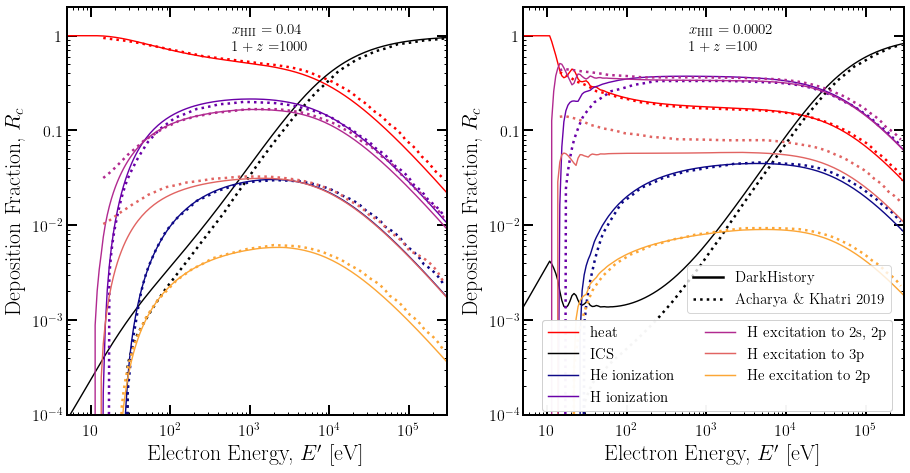

In [9]:
initEs = np.array([14, 30, 60, 100, 300, 3000])
fig, axarr = plt.subplots(1, 2, figsize=(15,7.5))
cmap = cm.plasma(np.linspace(0.,.8,5))
colors = {'heat':'r', 
          'ICS': 'k', 
          'He-ion': cmap[0], 
          'H-ion': cmap[1], 
          'H-exc2sp': cmap[2], 
          'H-exc3p': cmap[3], 
          'He-exc2p': cmap[4]}

leg1_DH, = axarr[0].plot(xes, np.ones_like(xes)*1e-20, color='k', label='DarkHistory')
leg1_AK, = axarr[0].plot(xes, np.ones_like(xes)*1e-20, color='k', linestyle=':', label='Acharya \& Khatri 2019')
leg2 = []
for i, num in enumerate(['04', '0002']):
    axarr[i].loglog()
    for j, chan in enumerate(files):
        ind1 = sum(eleceng<14)
        ind2 = sum(eleceng<2.93e5)
        axarr[i].plot(eleceng[ind1:ind2], Acharya_f[num][chan](eleceng[ind1:ind2]),
                      color=colors[chan], linestyle=':')
        leg2_temp, = axarr[i].plot(eleceng, DH_f[num][chan], 
                      color=colors[chan], linestyle='solid', linewidth=1.4, label=chan)
        leg2.append(leg2_temp)

    axarr[i].axis([5, 3e5, 1e-4, 2])
#     axarr[i].set_title(r'DH/Acharya f$_c$ Comparison, $x_{\mathrm{H}} = 0.$'+str(num), fontsize=22)
    axarr[i].text(6e2, 1, r'$x_{\mathrm{HII}} = 0.$'+str(num), fontsize=15)
    axarr[i].text(6e2, 0.7, r'$1+z = $'+str(int(rs_list[i])), fontsize=15)
    axarr[i].set_xlabel(r"Electron Energy, $E'$ [eV]", fontsize=22)
    axarr[i].set_ylabel(r'Deposition Fraction, $R_c$', fontsize=22)
    if i==1:
        axarr[i].legend(ncol=2, fontsize=15)
        legend1 = axarr[i].legend([leg1_DH, leg1_AK], ['DarkHistory', 'Acharya \& Khatri 2019'],
                                  loc=(0.43,0.25), fontsize = 15)
        legend2 = axarr[i].legend(leg2, labels, ncol=2, loc=(0.05,0.01), fontsize = 15)
        
        axarr[i].add_artist(legend1)
        axarr[i].add_artist(legend2)
    
plt.savefig(fig_dir+'AcharyaKhatri_CrossCheck.pdf')